In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nfl-player-contact-detection/test_baseline_helmets.csv
/kaggle/input/nfl-player-contact-detection/sample_submission.csv
/kaggle/input/nfl-player-contact-detection/train_baseline_helmets.csv
/kaggle/input/nfl-player-contact-detection/test_player_tracking.csv
/kaggle/input/nfl-player-contact-detection/train_player_tracking.csv
/kaggle/input/nfl-player-contact-detection/train_video_metadata.csv
/kaggle/input/nfl-player-contact-detection/test_video_metadata.csv
/kaggle/input/nfl-player-contact-detection/train_labels.csv
/kaggle/input/nfl-player-contact-detection/test/58172_003247_All29.mp4
/kaggle/input/nfl-player-contact-detection/test/58172_003247_Sideline.mp4
/kaggle/input/nfl-player-contact-detection/test/58172_003247_Endzone.mp4
/kaggle/input/nfl-player-contact-detection/test/58168_003392_Endzone.mp4
/kaggle/input/nfl-player-contact-detection/test/58168_003392_Sideline.mp4
/kaggle/input/nfl-player-contact-detection/test/58168_003392_All29.mp4
/kaggle/input/nfl-player-con

**Importing Necessary Packages**

For storage and manipulation of data we use numpy and pandas. For visualisations we use matplotlib.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Credit to Dino Wun for the idea to use these packages for video rendering in the notebook. https://www.kaggle.com/code/dinowun/eda-simplified-nfl-1st-and-future-pcd-b
!pip3 install moviepy
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from IPython.display import Video

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 24.1 MB/s eta 0:00:00
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110743 sha256=dcb9007430349569a85d3da0359a5934e91e9ccf01bb8a1c1ad59db4b41f9d4d
  Stored in directory: /root/.cache/pip/wheels/56/dc/2b/9cd600d483c04af3353d66623056fc03faed76b7518faae4df
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2022.5.0 requires fsspec==2022.5.0, but you have fsspec 2022.11.0 which is incompatible.


Reading the data for analysis.

In [3]:
baseline_helms_df = pd.read_csv('/kaggle/input/nfl-player-contact-detection/train_baseline_helmets.csv')
player_tracking_df = pd.read_csv('/kaggle/input/nfl-player-contact-detection/train_player_tracking.csv')
video_metadata_df = pd.read_csv('/kaggle/input/nfl-player-contact-detection/train_video_metadata.csv')
labels_df = pd.read_csv('/kaggle/input/nfl-player-contact-detection/train_labels.csv')

**Checking the head for each dataframe**

In [4]:
baseline_helms_df.head()

,game_play,game_key,play_id,view,video,frame,nfl_player_id,player_label,left,width,top,height
0,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,39947,H72,946,25,293,34
1,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,37211,H42,151,25,267,33
2,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,38590,H70,810,25,293,35
3,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,44822,H15,681,26,254,33
4,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,41944,V92,680,23,303,33


In [5]:
player_tracking_df.head()

,game_play,game_key,play_id,nfl_player_id,datetime,step,team,position,jersey_number,x_position,y_position,speed,distance,direction,orientation,acceleration,sa
0,58580_001136,58580,1136,44830,2021-10-10T21:08:20.900Z,-108,away,CB,22,61.59,42.60,1.11,0.11,320.33,263.93,0.71,-0.64
1,58580_001136,58580,1136,47800,2021-10-10T21:08:20.900Z,-108,away,DE,97,59.48,26.81,0.23,0.01,346.84,247.16,1.29,0.90
2,58580_001136,58580,1136,52444,2021-10-10T21:08:20.900Z,-108,away,FS,29,72.19,31.46,0.61,0.06,11.77,247.69,0.63,-0.33
3,58580_001136,58580,1136,46206,2021-10-10T21:08:20.900Z,-108,home,TE,86,57.37,22.12,0.37,0.04,127.85,63.63,0.69,0.62
4,58580_001136,58580,1136,52663,2021-10-10T21:08:20.900Z,-108,away,ILB,48,63.25,27.50,0.51,0.05,183.62,253.71,0.31,0.31


In [6]:
video_metadata_df.head()

,game_play,game_key,play_id,view,start_time,end_time,snap_time
0,58168_003392,58168,3392,Endzone,2020-09-11T03:01:43.134Z,2020-09-11T03:01:54.971Z,2020-09-11T03:01:48.134Z
1,58168_003392,58168,3392,Sideline,2020-09-11T03:01:43.134Z,2020-09-11T03:01:54.971Z,2020-09-11T03:01:48.134Z
2,58172_003247,58172,3247,Endzone,2020-09-13T19:30:42.414Z,2020-09-13T19:31:00.524Z,2020-09-13T19:30:47.414Z
3,58172_003247,58172,3247,Sideline,2020-09-13T19:30:42.414Z,2020-09-13T19:31:00.524Z,2020-09-13T19:30:47.414Z
4,58173_003606,58173,3606,Endzone,2020-09-13T19:45:07.527Z,2020-09-13T19:45:26.438Z,2020-09-13T19:45:12.527Z


In [7]:
labels_df.head()

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact
0,58168_003392_0_38590_43854,58168_003392,2020-09-11T03:01:48.100Z,0,38590,43854,0
1,58168_003392_0_38590_41257,58168_003392,2020-09-11T03:01:48.100Z,0,38590,41257,0
2,58168_003392_0_38590_41944,58168_003392,2020-09-11T03:01:48.100Z,0,38590,41944,0
3,58168_003392_0_38590_42386,58168_003392,2020-09-11T03:01:48.100Z,0,38590,42386,0
4,58168_003392_0_38590_47944,58168_003392,2020-09-11T03:01:48.100Z,0,38590,47944,0


**Checking Shape of dataframes**

In [8]:
baseline_helms_df.shape

(3783616, 12)

In [9]:
player_tracking_df.shape

(1353053, 17)

In [10]:
video_metadata_df.shape

(480, 7)

In [11]:
labels_df.shape

(4721618, 7)

**Checking for NaN values**

In [12]:
baseline_helms_df.isna().sum()

game_play        0
game_key         0
play_id          0
view             0
video            0
frame            0
nfl_player_id    0
player_label     0
left             0
width            0
top              0
height           0
dtype: int64

In [13]:
player_tracking_df.isna().sum()

game_play        0
game_key         0
play_id          0
nfl_player_id    0
datetime         0
step             0
team             0
position         0
jersey_number    0
x_position       0
y_position       0
speed            0
distance         0
direction        0
orientation      0
acceleration     0
sa               0
dtype: int64

In [14]:
video_metadata_df.isna().sum()

game_play     0
game_key      0
play_id       0
view          0
start_time    0
end_time      0
snap_time     0
dtype: int64

In [15]:
labels_df.isna().sum()

contact_id         0
game_play          0
datetime           0
step               0
nfl_player_id_1    0
nfl_player_id_2    0
contact            0
dtype: int64

# Baseline Helmets Dataframe

We start by taking a look at the baseline helmets file, this gives information about the imperfect baseline predictions for helmet boxes and player assignments from both sideline and end views

How do we change the x axis check marks to not all overlap?

<AxesSubplot:xlabel='game_play', ylabel='Count'>

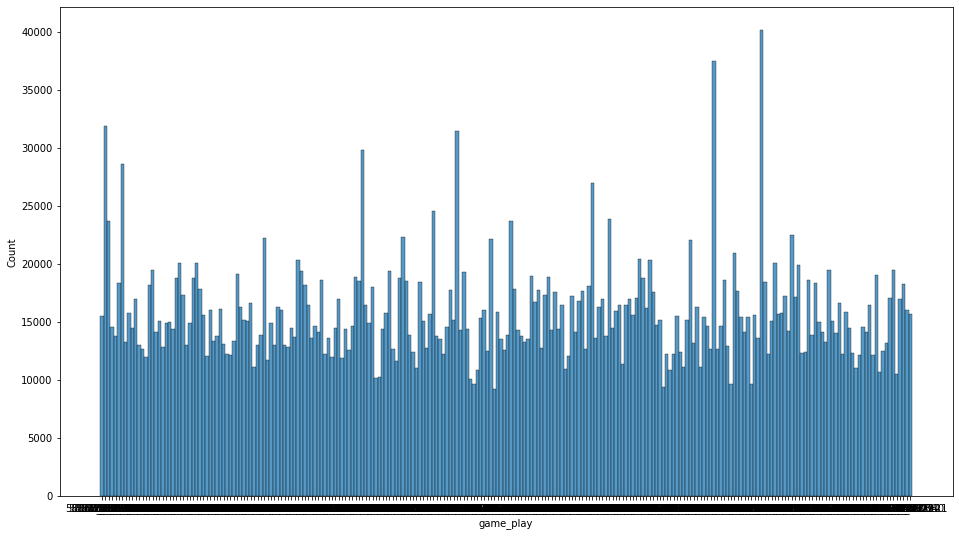

In [16]:
plt.figure(figsize=(16,9))
sns.histplot(baseline_helms_df['game_play'])
#set_xticks or xticks are the way to do it, just need to work out how to get them at the correct values
##plt.xticks()

Its nice to see the view expressed as a pie chart to see the percentages of each view 